# About this project
The data come from the [Supreme Court Forecasting Project](http://wusct.wustl.edu/data.php). The data description can be found [here](http://wusct.wustl.edu/media/trees.pdf). The data contains information of different cases and whether the justice Steven decided to reverse those cases or not. The goal of this project is to build a decision tree based on the past ruling of Justice Steven. Use visualization of the decision tree to generate insight about Justice Steven's ruling.

-----

In [1]:
%matplotlib inline
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [2]:
# read the data
steven = pd.read_csv('stevens.csv')
steven.head()

,Docket,Term,Circuit,Issue,Petitioner,Respondent,LowerCourt,Unconst,Reverse
0,93-1408,1994,2nd,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
1,93-1577,1994,9th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
2,93-1612,1994,5th,EconomicActivity,BUSINESS,BUSINESS,liberal,0,1
3,94-623,1994,1st,EconomicActivity,BUSINESS,BUSINESS,conser,0,1
4,94-1175,1995,7th,JudicialPower,BUSINESS,BUSINESS,conser,0,1


In [3]:
steven.Reverse.value_counts()

1    309
0    257
Name: Reverse, dtype: int64

* This is a relatively balanced dataset.

-----

In [4]:
steven.isnull().sum()

Docket        0
Term          0
Circuit       0
Issue         0
Petitioner    0
Respondent    0
LowerCourt    0
Unconst       0
Reverse       0
dtype: int64

* The data is very clean with no missing value.

-----

In [5]:
steven.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 9 columns):
Docket        566 non-null object
Term          566 non-null int64
Circuit       566 non-null object
Issue         566 non-null object
Petitioner    566 non-null object
Respondent    566 non-null object
LowerCourt    566 non-null object
Unconst       566 non-null int64
Reverse       566 non-null int64
dtypes: int64(3), object(6)
memory usage: 39.9+ KB


In [6]:
# split the data into features and respond
features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]

-----
# Build a Decision tree model to perform classification using Scikit-learn package.

In [7]:
# identify the categorical data
categorical = ['Circuit','Issue','Petitioner','Respondent','LowerCourt']
#categorical = ['Circuit']

'''
----------------------------
Perform onehot encoding
'''
X_encoded = pd.DataFrame()

for item in categorical:
    
    label_coder = LabelEncoder()
    #encoder that transforms string into label
    label = label_coder.fit_transform(X[item])
    
    onehot_coder = OneHotEncoder(sparse=False)
    #encoder that transforms label into multiple columns
    a = onehot_coder.fit_transform(label.reshape(-1,1))
    
    new_a = pd.DataFrame(a,columns=item + " : " + label_coder.classes_)
    
    for col in new_a:
        X_encoded[col] = new_a[col]

X_encoded['Unconst'] = X['Unconst']

X_encoded.head()

,Circuit : 10th,Circuit : 11th,Circuit : 1st,Circuit : 2nd,Circuit : 3rd,Circuit : 4th,Circuit : 5th,Circuit : 6th,Circuit : 7th,Circuit : 8th,...,Respondent : EMPLOYER,Respondent : GOVERNMENT.OFFICIAL,Respondent : INJURED.PERSON,Respondent : OTHER,Respondent : POLITICIAN,Respondent : STATE,Respondent : US,LowerCourt : conser,LowerCourt : liberal,Unconst
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [8]:
# spliting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_encoded,
                                                    Y,
                                                    random_state = 0, 
                                                    test_size = 0.3,
                                                    stratify = Y.Reverse)

# model training
model = DecisionTreeClassifier(min_samples_leaf = 10,criterion='gini',min_impurity_decrease=0.007)
model.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.007, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [9]:
# confusion matrix
Y_predict = model.predict(X_test)
confusion = confusion_matrix(Y_test, Y_predict)
print('Confusion matrix:\n',confusion)
print('Accuracy:',(confusion[0,0] + confusion[1,1]) / sum(sum(confusion)))

Confusion matrix:
 [[35 42]
 [17 76]]
Accuracy: 0.652941176471


In [10]:
# using simple binary responds to calculate the AUC
fpr, tpr, threshold = roc_curve(Y_test, Y_predict)

#print('FPR: ', fpr)
#print('TPR: ', tpr)
#print('Threshold: ', threshold)

print('AUC: ', roc_auc_score(Y_test, Y_predict))

#plt.plot(fpr,tpr)

AUC:  0.63587487781


In [11]:
# using probability responds to calculate the AUC
Y_predprob = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(Y_test, Y_predprob[:,1])

#print('FPR: ', fpr)
#print('TPR: ', tpr)
#print('Threshold: ', threshold)

print('AUC: ', roc_auc_score(Y_test, Y_predprob[:, 1]))
#plt.plot(fpr,tpr)

AUC:  0.709398128753


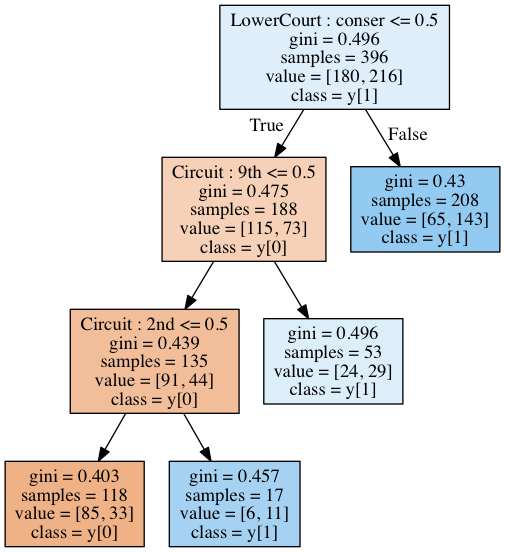

In [12]:
# export the decision tree graph
export_graphviz(model,out_file='steven.dot',
                feature_names=X_train.columns,
                class_names = True,
               leaves_parallel=False,
               filled = True)

!dot -Tpng steven.dot -o tree.png
Image('tree.png')

This Method used above can give us good enough prediction result. There are, however, some pitfalls:
* Every feature is onehot encoded. In Scikit-learn there is no way to perform splitting when there are more than two categorical values in each node.
* It is not easy to visualize the influence from different value of a specific feature.
* In the above visualization, the condition used to split the node is feature X <= 0.5. When it is true, it means the feature X is FALSE. This could cause incovenience during the interpretation.

-----

# Implementing a multi-way split decision tree model applicable to categorical data
Comparing with the one in Scikit-learn, this model can have deal with categorical data. It will also have multiple splits in each node. 

In [13]:
from catedecisiontree import *
%load_ext autoreload
%autoreload 2

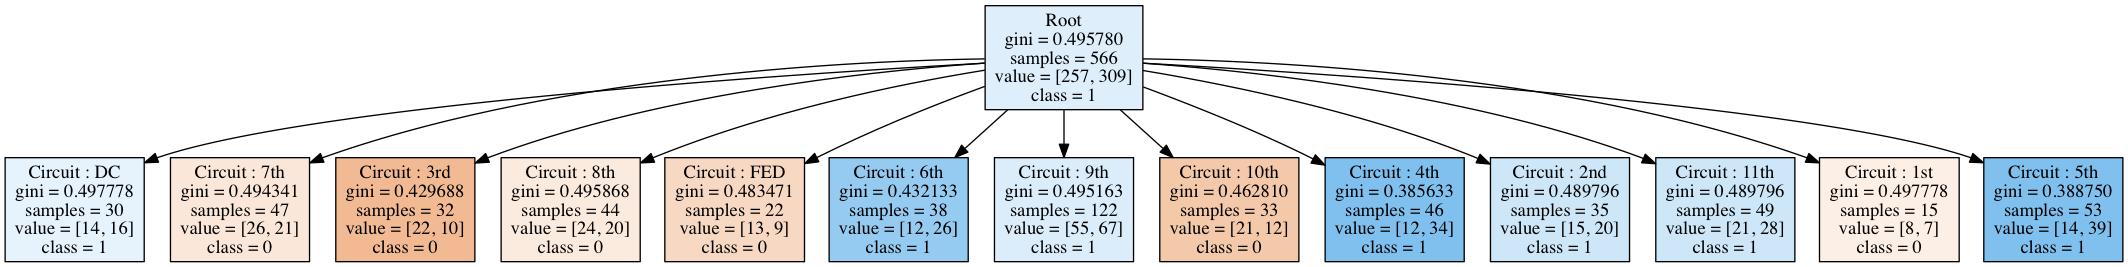

In [14]:
# split the data into features and respond
#features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
features = ['Circuit']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features, gini_decrease_min=0.0001)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o test.png
Image('test.png')

* We can see that Justice Steven is more likely to reverse the ruling from Circuit court: 4th, 5th and the 6th. 

-----

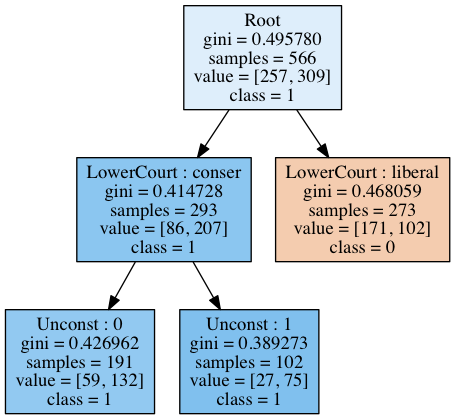

In [15]:
features = ['LowerCourt','Unconst']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features, gini_decrease_min=0.0001)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o test.png
Image('test.png')

* Notice the small gini_decrease_min parameter in oder to generate the split from Unconst feature. This means this feature is not very informative.

* The value of the feature is placed in the node along with the feature name, which is easier to interpretate.

-----

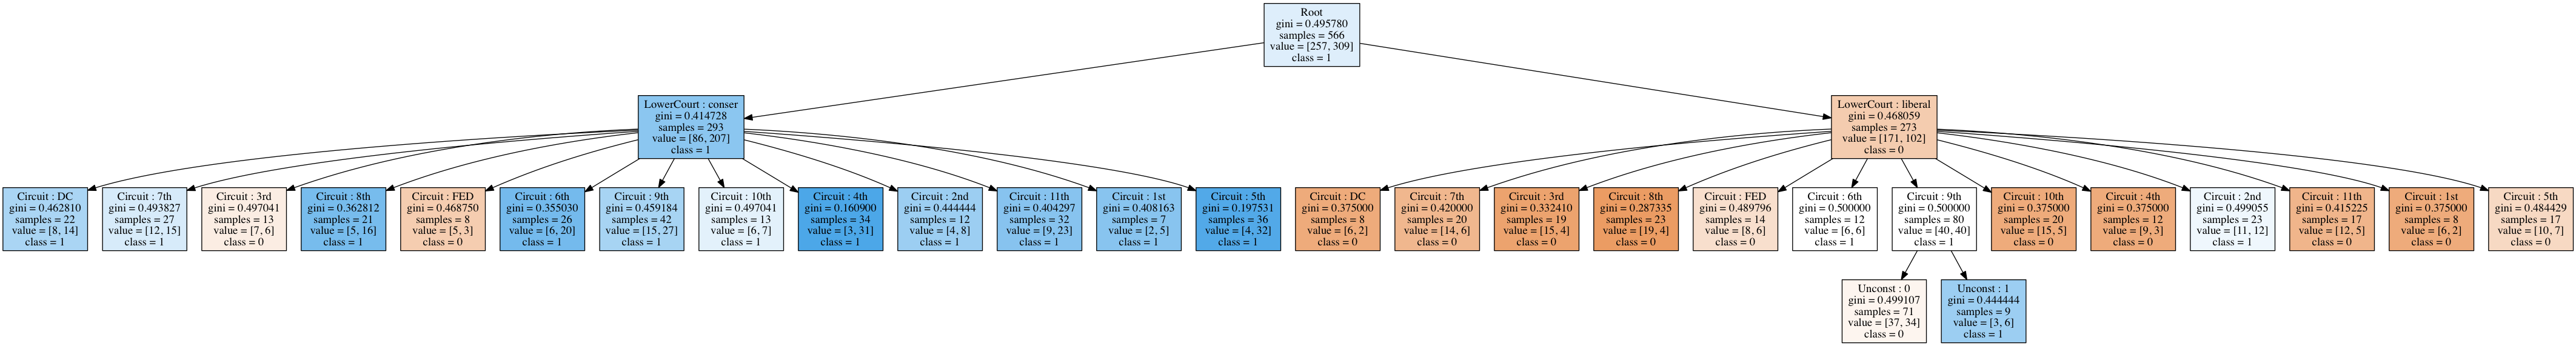

In [16]:
# split the data into features and respond
#features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
features = ['Unconst','LowerCourt', 'Circuit']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features, min_split=60, gini_decrease_min=0.0001)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o test.png
Image('test.png')

* When there are a lot of values for each feature, multi-way splitting might not be a good idea since the map will become too big to visualize.

-----

# Implementing a binary split decision tree applicable to categorical data

This is essentially an expenentially expensive way. Because we need to consider $2^{n-1}-1$ number of splits. Here we only consider the binary classification problem. Details can be found in https://www.mathworks.com/help/stats/splitting-categorical-predictors-for-multiclass-classification.html.
The illustration is shown as below:
    <img src="decisiontree.png">
   
-----

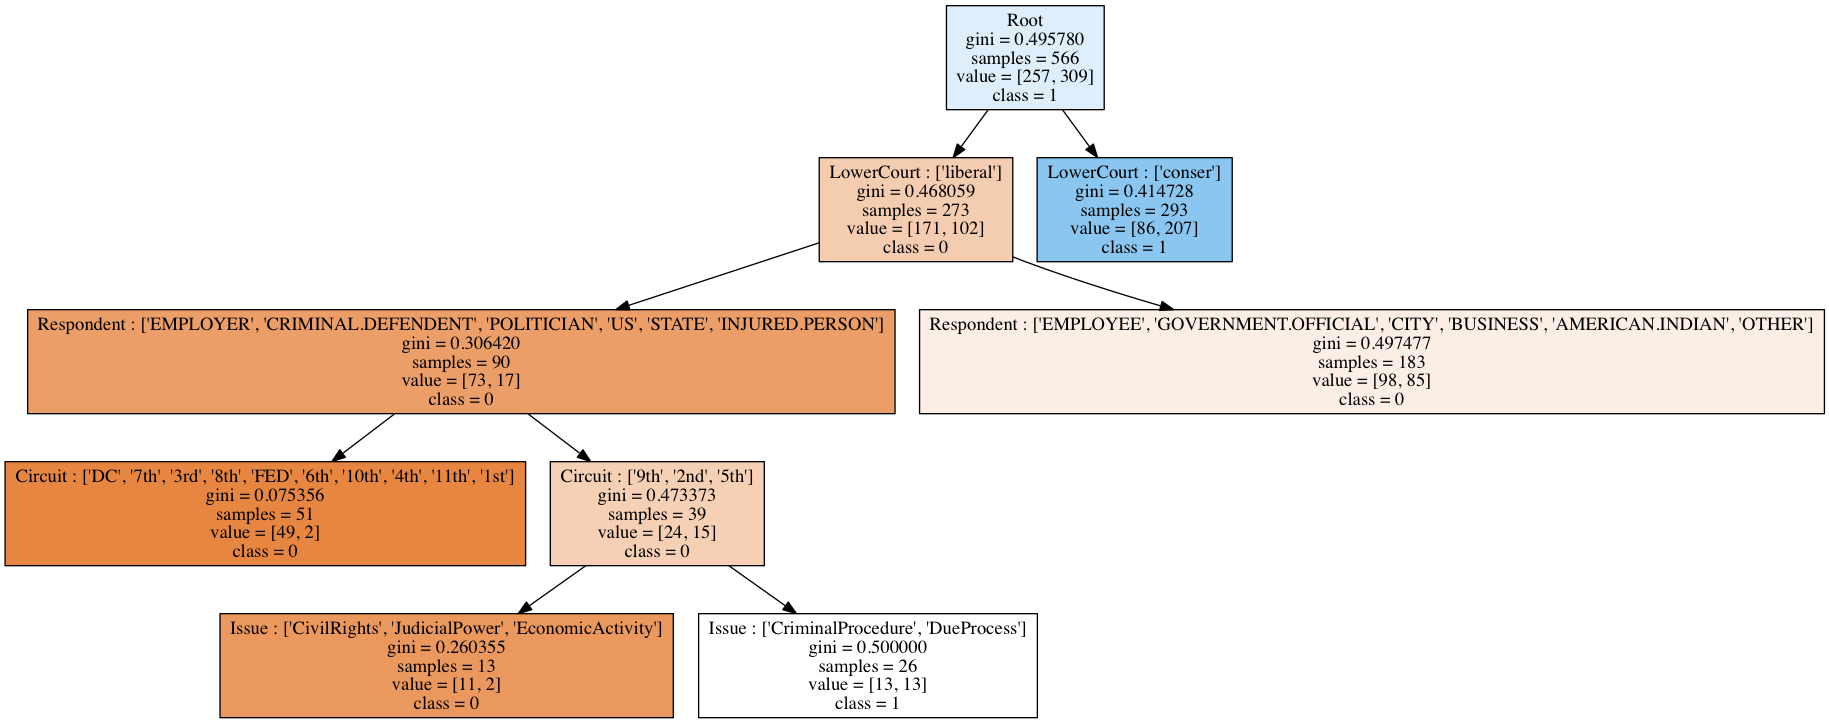

In [17]:
features = ['Circuit','Issue','Petitioner','Respondent','LowerCourt','Unconst']
#features = ['Unconst','LowerCourt']
responds = ['Reverse']
X = steven[features]
Y = steven[responds]
node = TreeGenerate(X, Y, features,split = 'binary', gini_decrease_min = 0.029, min_split=30)
export_graph(node, 'test.dot',filled = True)
!dot -Tpng test.dot -o testbinary.png
Image('testbinary.png')

This visualization is more compact because it binarily splits all values of a feature at each node.
What we can say about this plot:
* When the lower court's ruling is conservative, Steven's ruling is more uniform. 
* When the lower court's ruling is liberal, Steven's ruling depends more on the respondents. 

-----